# ARIMA

In [1]:
pip install SymPy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Python3\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install pmdarima

You should consider upgrading via the 'C:\Python3\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
import matplotlib.pyplot as plt
from matplotlib import pyplot
from math import sqrt
from numpy import split
from numpy import array
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sympy.solvers import solve
from sympy import Symbol

In [4]:
# USE PIVOTED GLOBAL
# SEPERATE DF INTO TWO DFS WITH JUST UR COMMODITIES ,YEAR,1 COMMODITY AT A TIME (Honey and then livestock&Dairy)
# DATE NEEDS to be in Date type, year row use the pandas function to datetime format = %year
# seasonal = True
# look for r2 close to zero as possible
# Split dairy and meat

In [5]:
# Importing dataframe
Global = pd.read_csv("C:/Users/airos/Documents/GitHub/FinalProjectEntity/Data/pivotedGlobal.csv")

Global.head()

,Unnamed: 0,Year,"Almonds, Shelled Basis","Apples, Fresh",Barley,"Coffee, Green",Corn,"Dairy, Milk, Fluid","Grapefruit, Fresh","Meat, Swine",Oats,"Oil, Soybean","Oilseed, Rapeseed",Rye,"Walnuts, Inshell Basis"
0,0,1998,235884.0,5282724.0,235884000.0,1.415304e+07,4.822010e+09,326151000.0,185000.0,4.740312e+12,247882000.0,4.176508e+09,5214000.0,2114000.0,205931.0
1,1,1999,377800.0,5746060.0,361362000.0,2.168172e+07,4.800686e+09,77534000.0,183000.0,4.476775e+12,239549000.0,3.797778e+09,662250000.0,2165000.0,256734.0
2,2,2000,318900.0,5675890.0,303700000.0,1.822200e+07,4.274204e+09,332092000.0,163000.0,2.395490e+11,251854000.0,3.946939e+09,307386000.0,1707000.0,216816.0
3,3,2001,376500.0,5065060.0,376488000.0,2.258928e+07,3.866379e+09,305319000.0,163000.0,2.518540e+11,241377000.0,4.354875e+09,312180000.0,1684000.0,276700.0
4,4,2002,494416.0,4605810.0,494416000.0,2.686065e+11,3.988483e+09,83581000.0,186000.0,3.871860e+11,227767000.0,4.433333e+09,332092000.0,2096000.0,255825.0


In [6]:
for col_name in Global.columns:
    print(col_name)

Unnamed: 0
Year
Almonds, Shelled Basis
Apples, Fresh
Barley
Coffee, Green
Corn
Dairy, Milk, Fluid
Grapefruit, Fresh
Meat, Swine
Oats
Oil, Soybean
Oilseed, Rapeseed
Rye
Walnuts, Inshell Basis


In [10]:
# Isolating 'Dairy, Milk, Fluid' first for ARIMA THEN 'Meat, Swine'
DMF = Global[['Dairy, Milk, Fluid', 'Year']]
DMF.head()

,"Dairy, Milk, Fluid",Year
0,326151000.0,1998
1,77534000.0,1999
2,332092000.0,2000
3,305319000.0,2001
4,83581000.0,2002


In [11]:
# Formatting Year to date datatype 
DMF['Year'] = pd.to_datetime(DMF['Year'], format='%Y')

C:\Users\airos\AppData\Local\Temp/ipykernel_4840/749516095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DMF['Year'] = pd.to_datetime(DMF['Year'], format='%Y')


In [12]:
## Setting Year as index
DMF.set_index('Year', inplace=True)
type(DMF)

pandas.core.frame.DataFrame

<AxesSubplot:xlabel='Year'>

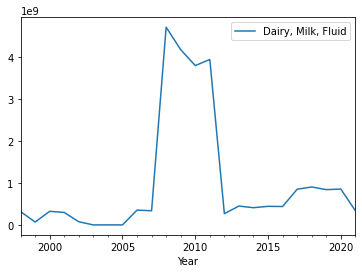

In [13]:
## Looking at linear plot of d,m,f, production
DMF.plot()

In [14]:
## Linear plot does not look stationary, there is an obvious stationary portion to the plot with a large spike from 2007 through 2012 in Dairy production

In [15]:
## Testing our finding against Augmented Dickey Fuller test
result=adfuller(DMF['Dairy, Milk, Fluid'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.6890240729345014
n_lags: 0.0042702160964055574
p-value: 0.0042702160964055574
Critial Values:
   1%, -4.01203360058309
Critial Values:
   5%, -3.1041838775510207
Critial Values:
   10%, -2.6909873469387753


## P value is providing a significant finding. We are going to accept the null hypothesis.
## The ADF Statistic is lower than our 1% critical value cuttoff, just above our 5% and higher than our 10% cuttoff indicating that Dairy production
## may not have a time depednent structure since it does not have a constant variance over time.

In [16]:
DMF

,"Dairy, Milk, Fluid"
Year,
1998-01-01,3.261510e+08
1999-01-01,7.753400e+07
2000-01-01,3.320920e+08
2001-01-01,3.053190e+08
2002-01-01,8.358100e+07
2003-01-01,8.782000e+06
2004-01-01,9.331000e+06
2005-01-01,9.247000e+06
2006-01-01,3.610910e+08


In [17]:
# Splitting the data for training and testing
train = DMF[:20]
test =  DMF[-4:]
train
test

,"Dairy, Milk, Fluid"
Year,
2018-01-01,911720000.0
2019-01-01,848220000.0
2020-01-01,861830000.0
2021-01-01,345506000.0


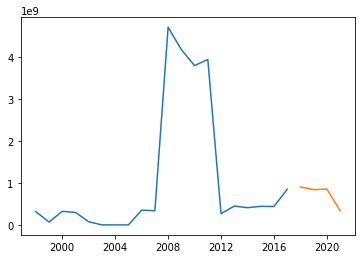

In [18]:
plt.plot(train)
plt.plot(test)

In [19]:
## Running auto_arima to obtain p, d, q variables
model = pm.auto_arima(DMF['Dairy, Milk, Fluid'], seasonal=False)
model

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [20]:
# ARIMA(order=(p=1, d=0, q=0)

In [22]:
# Manually Building Auto ARIMA model
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=907.567, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=900.615, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=904.143, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=913.245, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=898.870, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=900.624, Time=0.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=902.597, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=900.822, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=901.123, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=902.203, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=902.040, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=898.455, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=900.433, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=900.434, Time=0.04 sec
 ARIMA(1,0,0)(1,0,1)[12]         

# Best model confirmed p=1 d=0 q=0.
# model result  - ARIMA(1,0,0)(0,0,0)[12]: AIC=898.455

In [23]:
#Summary of the model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -447.227
Date:                Tue, 19 Jul 2022   AIC                            898.455
Time:                        23:31:57   BIC                            900.446
Sample:                             0   HQIC                           898.843
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7350      0.125      5.859      0.000       0.489       0.981
sigma2      1.561e+18   8.14e-21   1.92e+38      0.000    1.56e+18    1.56e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                42.19
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              48.40   Skew:                             1.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [24]:
# Forecasting on the test data
prediction = pd.DataFrame(arima_model.predict(n_periods = 4),index=test.index)
prediction.columns = ['predicted_values']
prediction

,predicted_values
Year,
2018-01-01,6.301083e+08
2019-01-01,4.631297e+08
2020-01-01,3.404004e+08
2021-01-01,2.501944e+08


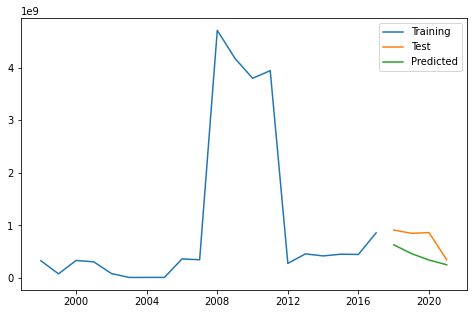

In [25]:
# Plotting against actual values
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
plt.show()

In [26]:
# Looking at R2 score
test['predicted_values'] = prediction
r2_score(test['Dairy, Milk, Fluid'], test['predicted_values'])

C:\Users\airos\AppData\Local\Temp/ipykernel_4840/983895852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_values'] = prediction


-1.4028479068608295

### INDICATES less accuracy?  would want to correct for this given more opportunity.

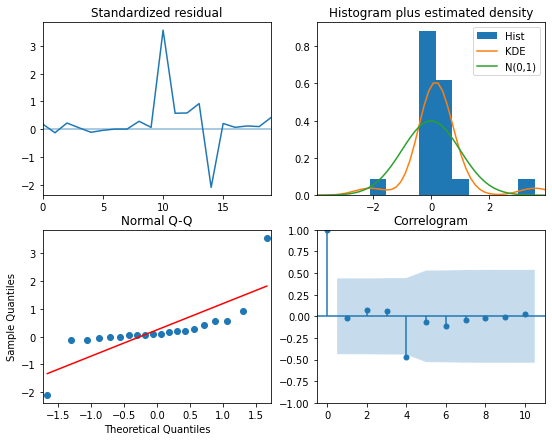

In [27]:
# Interpreting residual plots
arima_model.plot_diagnostics(figsize=(9,7))
plt.show()

### Upper left plot reveals pretty close variance on both sides of 0, Upper right plot reveals almost normality (I'd like to correct for this), Lower left reveals a slight deviation of the points from the trend line that also reveal some outliers, and the lower right reveals only one deviation thats not too far from the projected range we are looking at. 

In [28]:
# Creating new dataframe for future forecasting
future = {'Year':  [2022, 2023, 2024, 2025],
        'predicted_values': ['NaN', 'NaN', 'NaN', 'NaN']}

future = pd.DataFrame(future)
print (future)

   Year predicted_values
0  2022              NaN
1  2023              NaN
2  2024              NaN
3  2025              NaN


In [29]:
# Formatting Year to date datatype 
future['Year'] = pd.to_datetime(future['Year'], format='%Y')

In [30]:
## Setting Year as index
future.set_index('Year', inplace=True)
type(future)
future

,predicted_values
Year,
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN
2025-01-01,NaN


In [31]:
# Appending Future DF to justDairy DF
futureprediction = DMF.append(future)
futureprediction

C:\Users\airos\AppData\Local\Temp/ipykernel_4840/1597258169.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  futureprediction = DMF.append(future)


,"Dairy, Milk, Fluid",predicted_values
Year,,
1998-01-01,3.261510e+08,NaN
1999-01-01,7.753400e+07,NaN
2000-01-01,3.320920e+08,NaN
2001-01-01,3.053190e+08,NaN
2002-01-01,8.358100e+07,NaN
2003-01-01,8.782000e+06,NaN
2004-01-01,9.331000e+06,NaN
2005-01-01,9.247000e+06,NaN
2006-01-01,3.610910e+08,NaN


In [32]:
# Setting number of points to forecast
h=28
# Generating forecast
forecast2 = pd.DataFrame(arima_model.predict(h), index=futureprediction.index)
forecast2.columns = ['predicted_values']
forecast2

,predicted_values
Year,
1998-01-01,6.301083e+08
1999-01-01,4.631297e+08
2000-01-01,3.404004e+08
2001-01-01,2.501944e+08
2002-01-01,1.838929e+08
2003-01-01,1.351613e+08
2004-01-01,9.934361e+07
2005-01-01,7.301757e+07
2006-01-01,5.366793e+07


#### DOES NOT REVEAL THE GRAPH WE WANT

#### Visualize forecast with training data
time = np.arange(train.shape[0] + h)

#### Slice the x-axis to only plot the training data as the color black
plt.plot(time[:train.shape[0]], train, c = 'blue')

#### Slice the x-axis to plot our forecast after the training data as the color red
plt.plot(time[train.shape[0]:], forecast2, c = 'black')

#### Set axis labels
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()




# 2023 Honey Prediction Values based off of Dairy Commodity Forecasting


# ******Using Dairy+Honey linear regression equation performed in Cat1Pivot; (Deq) y  = -455.0467(Honey)+117000000.0) we can solve for Honey.

### US Dairy production for 2023 is forecasted at 2.861551e+05, or 286155.1 Metric Tons.


### if we plug our values into the Linear regression formula Honey Production = 
### 286155.1 = -455.0467(Honey)+117000000.0 (solving below)
### So Honey production is predicted to produce 256487.62 metric tons in 2023.

In [34]:
 286155.1 - 117000000.0 

-116713844.9

In [35]:
### -116713844.9 = -455.0467(Honey)

In [36]:
-116713844.9/-455.0467

256487.6196223377

In [37]:
### honey = 256487.62

In [ ]:
Meat.head()

In [ ]:
# Formatting Year to date datatype 
Meat['Year'] = pd.to_datetime(Meat['Year'], format='%Y')

In [ ]:
## Setting Year as index
Meat.set_index('Year', inplace=True)
type(Meat)

In [ ]:
## Looking at linear plot of d,m,f, production
Meat.plot()

## Linear plot does not look stationary, there is obvious inconsistency across the plot every three years or so. May be due tertiary other variables.
# dIFFERENCING!!! LOOK IT UP!

In [ ]:
## Testing our finding against Augmented Dickey Fuller test
result=adfuller(Meat['Meat, Swine'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

## P value is providing an insignificant finding (>0.05). We are going to reject the null hypothesis.
## The ADF Statistic is lower than our all critical value cuttoffs revealing a possible time depednent structure since it MAY have a constant variance over time.

In [ ]:
Meat

In [ ]:
# Splitting the data for training and testing
train = Meat[:20]
test =  Meat[-4:]
train
test

In [ ]:
plt.plot(train)
plt.plot(test)

In [ ]:
## Running auto_arima to obtain p, d, q variables
model = pm.auto_arima(Meat['Meat, Swine'], seasonal=False)
model

In [ ]:
# p=0 d=1 q=0

In [ ]:
# Manually Building Auto ARIMA model
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=False, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

In [ ]:
# Best model confirmed p=0 d=1 q=1, our ARIMA class is I(1)....??
# model result  - ARIMA(0,1,1)(0,0,0)[0]: AIC=1138.136, Time=0.02 sec

In [ ]:
#Summary of the model
arima_model.summary()

In [ ]:
# Forecasting on the test data
prediction = pd.DataFrame(arima_model.predict(n_periods = 4),index=test.index)
prediction.columns = ['predicted_values']
prediction

In [ ]:
# Plotting against actual values
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
plt.show()

In [ ]:
# Looking at R2 score
test['predicted_values'] = prediction
r2_score(test['Meat, Swine'], test['predicted_values'])

# Questioning distance from zero. It is negative.........

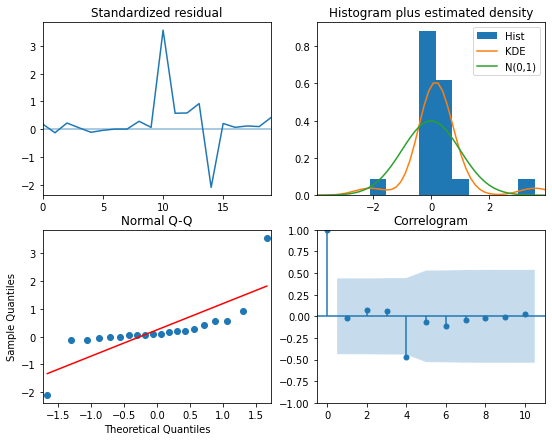

In [38]:
# Interpreting residual plots
arima_model.plot_diagnostics(figsize=(9,7))
plt.show()